In [57]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Loading the train data
train_data = tfds.load(name='malaria', as_supervised=True)['train'];

# Set batch size and resized image size
BATCH=128
IMG_SIZE=80

### Load the dataset.

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
27558
(103, 103, 3)
(106, 121, 3)
(139, 142, 3)
(130, 118, 3)
(121, 109, 3)


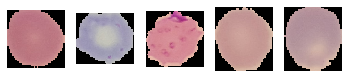

In [58]:
# Purely plotting
print(train_data)
print(len(train_data))

iterator=train_data.__iter__()
fig, ax = plt.subplots(1,5)
maxi=0
for i in range(5):

    # Readout an image and the corresponding label.
    img,lbl=iterator.get_next()
    print(img.shape)
    ax[i].imshow(img, interpolation='nearest')
    ax[i].axis("off")
  


### Build the TensorFlow dataset: Input pipeline

In [59]:
# Function to resize a single image tensor to uniform size
def transfi(tensor):
    result=tf.image.resize_with_pad(tensor,IMG_SIZE,IMG_SIZE)/256
    
    return result

# Convert input string into onehot tensor using above function
# Conver input label into onehot tensor using tf.one_hot
def transfi_data_input(input,label):
    return (transfi(input), tf.one_hot(label,depth=2))

# Process loaded training dataset

train_dataset = train_data.map(transfi_data_input)
train_dataset = train_dataset.batch(BATCH)


# Split into train and test
train_set=train_dataset.take(int(0.8*len(train_dataset)))
test_set=train_dataset.skip(int(0.8*len(train_dataset)))


### Build the model.

In [60]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    def __init__(self):
        super(Model, self).__init__()

        # Define the three layers.
        # Explain why we used 3 convolutional layers and the number of filters and the strides and no padding? 
        self.conv1=tf.keras.layers.Conv2D(filters=30,kernel_size=3,strides=(1,1),activation=tf.keras.activations.relu,input_shape=(IMG_SIZE,IMG_SIZE,3))
        self.pool1=tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None)
        self.conv2=tf.keras.layers.Conv2D(filters=60,kernel_size=3,strides=(1,1),activation=tf.keras.activations.relu)
        self.pool2=tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None)
        self.conv3=tf.keras.layers.Conv2D(filters=60,kernel_size=3,strides=(1,1),activation=tf.keras.activations.relu)
        self.pool3=tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None)
        self.conv4=tf.keras.layers.Conv2D(filters=60,kernel_size=3,strides=(1,1),activation=tf.keras.activations.relu)
        self.pool4=tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None)
        self.global1=tf.keras.layers.GlobalAveragePooling2D()
        self.hidden1 = tf.keras.layers.Dense(units=64, activation=tf.keras.activations.sigmoid)

        self.hidden2 = tf.keras.layers.Dense(units=64, activation=tf.keras.activations.sigmoid)
        self.output1 = tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax)
    def call(self, inputs):      
        # Define the forward step.
        x = self.pool1(self.conv1(inputs))

        x = self.pool2(self.conv2(x))

        x = self.pool3(self.conv3(x))

        x = self.pool4(self.conv4(x))

        x = self.global1(x)

        x = self.hidden2(self.hidden1(x))

        x = self.output1(x)
        
        return x
        #return self.output1(self.hidden2(self.hidden1(self.global1(self.conv4(self.pool3(self.conv3(self.pool2(self.conv2(self.pool1(self.conv1(inputs)))))))))))

### Train the model.

In [61]:
#taken from the courseware-notebook

def train_step(model, input, target, loss_function, optimizer):

    with tf.GradientTape() as tape:
        # Get the prediction from the model
        prediction = model(input)
        # Compute the loss
        loss = loss_function(target, prediction)

        #Get the gradients of the variables by feeding the loss
        gradients = tape.gradient(loss, model.trainable_variables)
      
    # Apply gradients to the model variables
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 

def test(model, test_data, loss_function):
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
      # Obtain the prediction from the model
        prediction = model(input)

        # Get the test loss for the given sample
        sample_test_loss = loss_function(target, prediction)

        # Compute the labels based on the predictions and compare to the target for accuracy
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)

        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    # Average loss and accuracy
    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy
  



In [ ]:
#taken from the courseware-notebook, the running average was removed

tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = 0.0001

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy.
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. 
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_set = train_set.shuffle(buffer_size=BATCH)

    #training (and checking in with training)
    train_loss=0
    # testmax=3000
    # i=0
    for (inputs,target) in train_set:
        train_loss += train_step(model, inputs, target, cross_entropy_loss, optimizer)
        # i+=1
        # if i>=testmax:
        #   break
    train_losses.append(train_loss/min(testmax,len(train_set)))

    #testing
    if epoch%1==0:
      test_loss, test_accuracy = test(model, test_set, cross_entropy_loss)
      test_losses.append(test_loss)
      test_accuracies.append(test_accuracy)
    else:
      test_losses.append(test_losses[-1])



Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9
Epoch: __ 10
Epoch: __ 11
Epoch: __ 12
Epoch: __ 13
Epoch: __ 14
Epoch: __ 15
Epoch: __ 16
Epoch: __ 17
Epoch: __ 18
Epoch: __ 19
Epoch: __ 20
Epoch: __ 21
Epoch: __ 22
Epoch: __ 23
Epoch: __ 24


### Visualize the training progress.

In [1]:
#taken from the courseware notebook

# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
x = list(range(num_epochs));
line1, = plt.plot(x, train_losses, label='training')
line2, = plt.plot(x, test_losses, label='test')
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()


NameError: ignored